# Inés Dataset
To evaluate Tangles on real world data, we have obtained the dataset from the thesis of Inés. She has used an embedding algorithm on it and has visually inspected, which elements are closer together.

We will do the same with majority-Tangles.

## Data preparation


In [1]:
import sys
sys.path.append("..")
from pathlib import Path
import pandas as pd
import re
import numpy as np
import altair as alt
from typing import Optional
from tangles.plotting import plot_soft_predictions
from tangles.data_types import Data
from sklearn.utils import Bunch
from cblearn.embedding import SOE
from cblearn.preprocessing import triplets_from_mostcentral, triplets_from_oddoneout
import matplotlib.pyplot as plt
from triplets import triplets_to_majority_neighbour_cuts
from estimators import OrdinalTangles

In [2]:
# getting all the folders that contain triplet data
dataset_root = Path(r"/Users/almico/datasets/2021_similarity-triplets_object-images_ines-bsc")
data_root = dataset_root / "data_similarity_judgements"
vp_folders = [p for p in data_root.iterdir() if p.is_dir() and re.match(r"VP_\d+", p.stem) is not None]
dfs = []
# bringing the data into a a more workable format
for vp in vp_folders:
    experiment_re = r"similarity_judgements_(\d+)_session_(.*).csv"
    csv_files = [p for p in vp.iterdir() if re.match(experiment_re, p.stem) is not None]
    for f in vp.iterdir():
        search = re.search(experiment_re, f.name)
        if search is None:
            continue
        vp_number = search.group(1)
        kind = search.group(2)
        dfs.append(pd.read_csv(f).assign(vp_number=vp_number, exp_kind = kind))
    
df = pd.concat(dfs)
# There was apparently some error in naming 
df.replace("fork_plastic_light.jp","fork_plastic_light.jpg", inplace=True)
df.head()

,subj,age,session,trial,RT,response,imagenameleft,imagenamemiddle,imagenameright,imageset,vp_number,exp_kind
0,1.0,27.0,odd,1.0,1.961037,left,letter_opener_10s.jpg,key_08s.jpg,key_07s.jpg,action,1,odd
1,1.0,27.0,odd,2.0,1.552606,right,stump_08s.jpg,tree_ines.jpg,stick_insect_09.jpg,taxonomic,1,odd
2,1.0,27.0,odd,3.0,2.102521,left,leaf_04s.jpg,stick_insect_09.jpg,bee_01b.jpg,taxonomic,1,odd
3,1.0,27.0,odd,4.0,4.968988,left,screwdriver_04s.jpg,coin_14s.jpg,key_01b.jpg,action,1,odd
4,1.0,27.0,odd,5.0,1.705614,middle,pitchfork_02s.jpg,hay_10s_cut.jpg,pitchfork_09s.jpg,thematic,1,odd


This is the raw data. We will now process this into a triplet-response format.
For all of this, we will provide functions that operate on dataframes, since we ideally want to filter the dataframe before (to access VPs, imageset, ...).

First, we will provide a method to append triplets to the dataframe (accessing the imagenameleft and imagenamemiddle etc.). This will require a translation imagenames -> triplet index.

In [3]:
def append_triplets(df: pd.DataFrame) -> np.ndarray:
    """
    Appends columns to df that contain triplet information.
    Changes DF in-place.

    Returns numpy array of unique names that were used for images.
    If a triplet contains a number, its image name corresponds to its index in the array.
    """
    imagenames = df[["imagenameleft", "imagenamemiddle", "imagenameright"]]
    unique_names = np.unique(imagenames.to_numpy().flatten())
    indices = np.argmax(imagenames.to_numpy()[:, :, None] == unique_names[None, None, :], axis=2)

    triplets = indices
    responses = np.argmax(df["response"].to_numpy()[:, None] == np.array(["left", "middle", "right"])[None, :], axis=1)

    df[["triplet_left", "triplet_middle", "triplet_right"]] = triplets
    df["triplet_response"] = responses
    return unique_names


Next, we want to provide a dictionary that gives us some more information about the images.
As the kinds of images that are included depends on the query, we will provide a dynamic function to query the dataframe.

In [4]:
def make_image_info_dict(unique_names) -> dict:
    image_info_dict = {}
    image_number_correspondence = np.arange(0, unique_names.size)
    for i, name in enumerate(unique_names):
        num = image_number_correspondence[i]
        image_info_dict[name] = {"idx": num}
    for imageset in ["action", "taxonomic", "thematic"]:
        for im in (dataset_root / f"{imageset}_stimuli").iterdir():
            if im.name in image_info_dict:
                image_info_dict[im.name]["imageset"] = imageset
                image_info_dict[im.name]["class"] = re.search(r"([a-z]+)_.*\.jpg", im.name).group(1)
    # now revert the dictionary to make better use of it
    image_info_dict = {v["idx"]: {"name": k, "imageset": v["imageset"], "class": v["class"]} for k, v in image_info_dict.items()}
    return image_info_dict

Finally, we can give a function that queries the dataset under the desired conditions 
and returns a bunch object that contains the necessary information.

In [5]:
def query_ines_dataset(df: pd.DataFrame, vp: Optional[str], imageset: Optional[str], exp_kind: Optional[str]) -> Bunch:
    if vp == None and imageset == None and exp_kind == None:
        raise ValueError("Must specify at least one of vp, imageset, exp_kind")
    mask = np.ones(df.shape[0], dtype=bool)
    if vp_number is not None:
        mask = mask & (df["vp_number"] == vp_number)
    if imageset is not None:
        mask = mask & (df["imageset"] == imageset)
    if exp_kind is not None:
        mask = mask & (df["exp_kind"] == exp_kind)

    df_filtered = df[mask].copy()
    triplet_image_names = append_triplets(df_filtered)
    t, r = df_filtered[["triplet_left", "triplet_middle", "triplet_right"]].to_numpy(), df_filtered["triplet_response"].to_numpy()
    image_info_dict = make_image_info_dict(triplet_image_names)
    return Bunch(raw_df=df_filtered, triplets=t, responses=r, image_info=image_info_dict, vp_number=vp_number, imageset=imageset, exp_kind=exp_kind)

## Exploring the dataset
We will now see what insights we can gain from the data.

### Odd similarity triplets
We will start out with the odd triplets, as they were easier to embed (see Bachelor thesis
of Inés).

In [39]:
imageset = "thematic"
exp_kind = "odd"
vp_number = "2"
data = query_ines_dataset(df, vp_number, imageset, exp_kind)
t = triplets_from_oddoneout(data.triplets, data.responses)
r = np.ones(t.shape[0])

In [47]:
embedding = SOE(n_components = 2, random_state=2).fit_transform(t,r)
cuts = triplets_to_majority_neighbour_cuts(t, radius = 1)
tangles = OrdinalTangles(3)
tangles_pred = tangles.fit_predict(cuts)

In [48]:
classes = [data.image_info[i]["class"] for i in data.image_info.keys()]
df_plot = pd.DataFrame({"x": embedding[:, 0], "y": embedding[:, 1], "tangles": tangles_pred.astype(int), "class": classes})
alt.Chart(df_plot).mark_circle(size=70).encode(x="x", y="y", color="tangles:N").display()
alt.Chart(df_plot).mark_circle(size=70).encode(x="x", y="y", color="class").display()

alt.Chart(...)

alt.Chart(...)

In [51]:
cuts = triplets_to_majority_neighbour_cuts(t, radius = 1/4)

for a in range(3,10):
    for radius in [1/4, 1/3, 1/2, 1]:
        cuts = triplets_to_majority_neighbour_cuts(t, radius = radius)
        tangles_pred = OrdinalTangles(a).fit_predict(cuts)
        df_plot = pd.DataFrame({"x": embedding[:, 0], "y": embedding[:, 1], "tangles": tangles_pred.astype(int), "class": classes})
        alt.Chart(df_plot).mark_circle(size=70).encode(x="x", y="y", color="tangles:N").properties(title=f"a={a}, radius={radius}")#.display()

We can see that a radius of 1 is generally okay. Lowering the radius makes the cuts lower, but that is not that important, since the tangles-algorithm does its work.

Maybe soft cuts can really shine here.

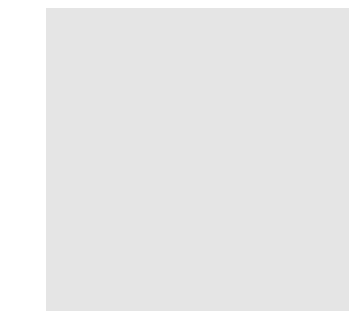

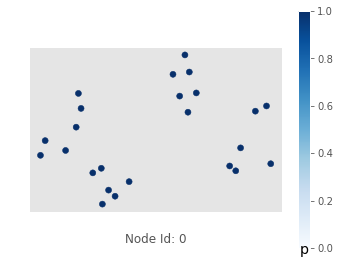

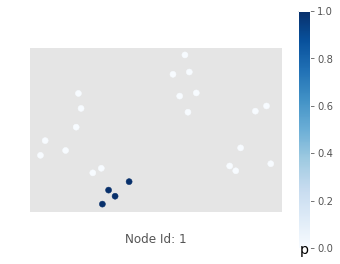

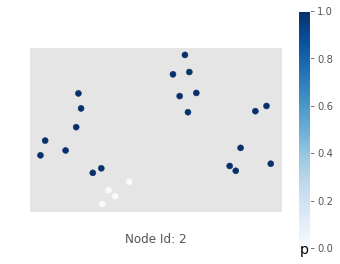

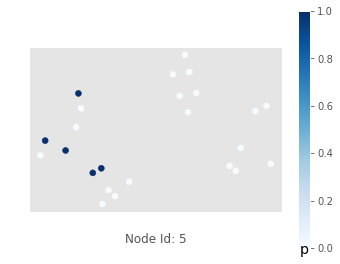

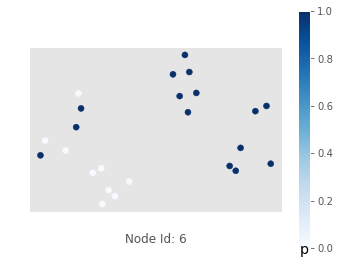

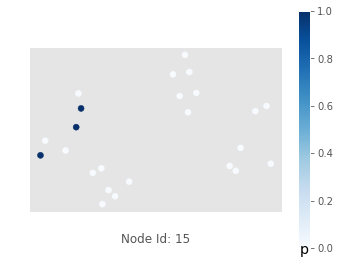

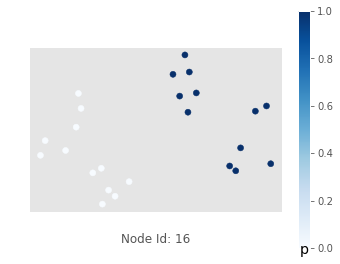

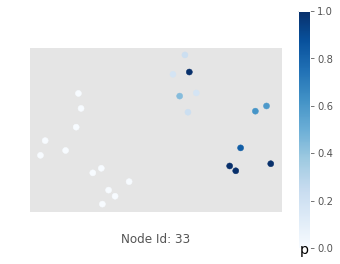

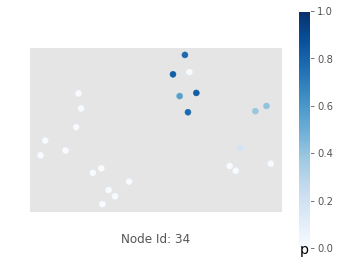

In [53]:
cuts = triplets_to_majority_neighbour_cuts(t, radius = 1/4)
tangles = OrdinalTangles(3)
tangles_pred = tangles.fit_predict(cuts)
#
aux_data = Data(embedding, np.ones(cuts.shape[0]))
plot_soft_predictions(aux_data, tangles.contracted_tangles_tree_, tangles.cuts_.values)
